<a href="https://colab.research.google.com/github/jenny005/Reinforcement-Learning-by-Sutton-Barto/blob/main/Chapter_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example 6.2 Random Walk

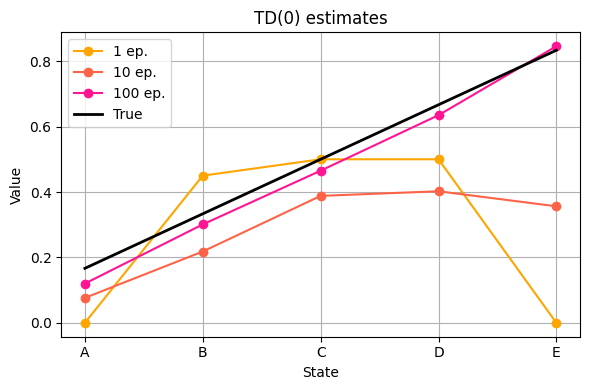

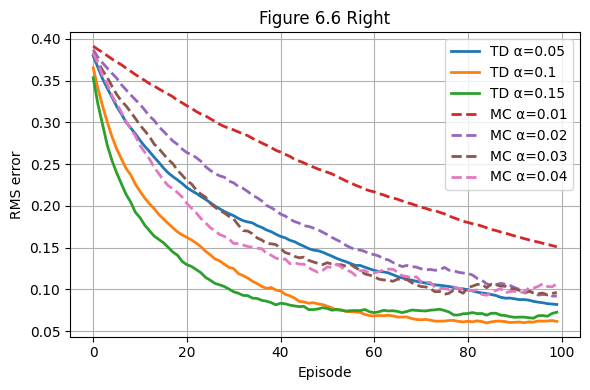

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# --- Setup for 5-state random walk ---
states = ['A','B','C','D','E']
true_values = np.array([1/6,2/6,3/6,4/6,5/6])
n_states = len(states)

def generate_episode():
    s = 2
    ep = [s]
    while s not in (-1,5):
        s += np.random.choice([-1,1])
        ep.append(s)
    r = 1.0 if s==5 else 0.0
    return ep, r

# TD(0) value estimates after N episodes
def td_estimates(episode_counts, alpha=0.1):
    out = []
    for N in episode_counts:
        V = np.ones(n_states)*0.5
        V[0]=V[-1]=0
        for _ in range(N):
            ep, _ = generate_episode()
            for i in range(len(ep)-1):
                s, s2 = ep[i], ep[i+1]
                if 0<=s<n_states and 0<=s2<n_states:
                    V[s] += alpha*(V[s2]-V[s])
                elif 0<=s<n_states:
                    G = 1.0 if s2==5 else 0.0
                    V[s] += alpha*(G-V[s])
        out.append(V.copy())
    return out

# RMS error curves for TD and MC
def td_rms(alpha, episodes=100, runs=100):
    errs = np.zeros(episodes)
    for _ in range(runs):
        V = np.ones(n_states)*0.5; V[0]=V[-1]=0
        for t in range(episodes):
            ep,_ = generate_episode()
            for i in range(len(ep)-1):
                s,s2 = ep[i],ep[i+1]
                if 0<=s<n_states and 0<=s2<n_states:
                    V[s]+=alpha*(V[s2]-V[s])
                elif 0<=s<n_states:
                    G=1.0 if s2==5 else 0.0
                    V[s]+=alpha*(G-V[s])
            errs[t] += np.sqrt(np.mean((V-true_values)**2))
    return errs/runs

def mc_rms(alpha, episodes=100, runs=100):
    errs = np.zeros(episodes)
    for _ in range(runs):
        V = np.ones(n_states)*0.5; V[0]=V[-1]=0
        for t in range(episodes):
            ep,R = generate_episode()
            for s in ep[:-1]:
                if 0<=s<n_states:
                    V[s]+=alpha*(R-V[s])
            errs[t]+=np.sqrt(np.mean((V-true_values)**2))
    return errs/runs

# --- First figure: estimated values ---
episode_counts = [1,10,100]
estimates = td_estimates(episode_counts, alpha=0.1)

plt.figure(figsize=(6,4))
colors = ['orange','tomato','deeppink']
for V, N, c in zip(estimates, episode_counts, colors):
    plt.plot(states, V, marker='o', color=c, label=f'{N} ep.')
plt.plot(states, true_values, color='black', lw=2, label='True')
plt.xlabel('State'); plt.ylabel('Value'); plt.title('TD(0) estimates')
plt.legend(); plt.grid(True); plt.tight_layout()

# --- Second figure: RMS error vs episodes ---
episodes = 100
td_alphas = [0.05,0.1,0.15]
mc_alphas = [0.01,0.02,0.03,0.04]

plt.figure(figsize=(6,4))
for a in td_alphas:
    plt.plot(td_rms(a),    label=f'TD α={a}',    lw=2)
for a in mc_alphas:
    plt.plot(mc_rms(a), '--', label=f'MC α={a}', lw=2)
plt.xlabel('Episode'); plt.ylabel('RMS error')
plt.title('Figure 6.6 Right')
plt.legend(); plt.grid(True); plt.tight_layout()

plt.show()


## Q-learning can be off-policy without using important sampling

# Sarsa (on-policy TD control) for estimating Q=q*

## Example 6.5: Windy Gridworld

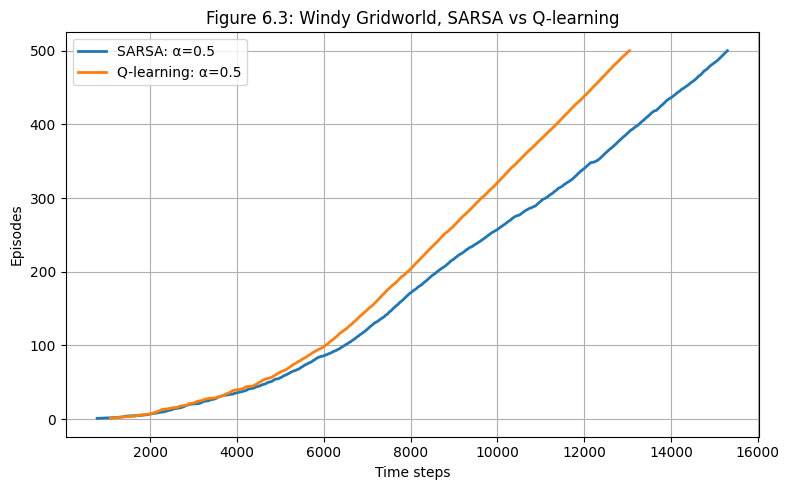

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Windy Gridworld (Example 6.5) ---
class WindyGridworldEnv:
    def __init__(self, height=7, width=10, wind=None, start=(3,0), goal=(3,7)):
        self.height, self.width = height, width
        self.wind = wind if wind else [0,0,0,1,1,1,2,2,1,0]
        self.start, self.goal = start, goal

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        x,y = self.agent_pos
        w = self.wind[y]
        x -= w
        if action==0:    x-=1      # up
        elif action==1:  x+=1      # down
        elif action==2:  y-=1      # left
        elif action==3:  y+=1      # right
        x = max(0, min(self.height-1, x))
        y = max(0, min(self.width-1,  y))
        self.agent_pos = (x,y)
        return (x,y), -1, (x,y)==self.goal, {}

# ε-greedy policy
def epsilon_greedy(Q, state, ε=0.1):
    if random.random() < ε:
        return random.randrange(4)
    return int(np.argmax(Q[state]))

# SARSA returns list of steps per episode
def sarsa(env, episodes, α=0.5, γ=1.0, ε=0.1):
    Q = {(i,j): np.zeros(4) for i in range(env.height) for j in range(env.width)}
    steps = []
    for _ in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, ε)
        t = 0
        done = False
        while not done:
            nxt, r, done, _ = env.step(action)
            nxt_a = epsilon_greedy(Q, nxt, ε)
            Q[state][action] += α*(r + γ*Q[nxt][nxt_a] - Q[state][action])
            state, action = nxt, nxt_a
            t += 1
        steps.append(t)
    return steps

# Q-learning returns list of steps per episode
def q_learning(env, episodes, α=0.5, γ=1.0, ε=0.1):
    Q = {(i,j): np.zeros(4) for i in range(env.height) for j in range(env.width)}
    steps = []
    for _ in range(episodes):
        state = env.reset()
        t = 0
        done = False
        while not done:
            action = epsilon_greedy(Q, state, ε)
            nxt, r, done, _ = env.step(action)
            best_next = np.max(Q[nxt])
            Q[state][action] += α*(r + γ*best_next - Q[state][action])
            state = nxt
            t += 1
        steps.append(t)
    return steps

# --- Run both algorithms ---
env = WindyGridworldEnv()
episodes = 500

sarsa_steps = sarsa(env, episodes)
q_steps     = q_learning(env, episodes)

# --- Compute cumulative time steps ---
cum_sarsa = np.cumsum(sarsa_steps)
cum_q     = np.cumsum(q_steps)
eps_idx   = np.arange(1, episodes+1)

# --- Plot Figure 6.3 style ---
plt.figure(figsize=(8,5))
plt.plot(cum_sarsa, eps_idx, label='SARSA: α=0.5',     linewidth=2)
plt.plot(cum_q,     eps_idx, label='Q-learning: α=0.5', linewidth=2)
plt.xlabel("Time steps")
plt.ylabel("Episodes")
plt.title("Figure 6.3: Windy Gridworld, SARSA vs Q-learning")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


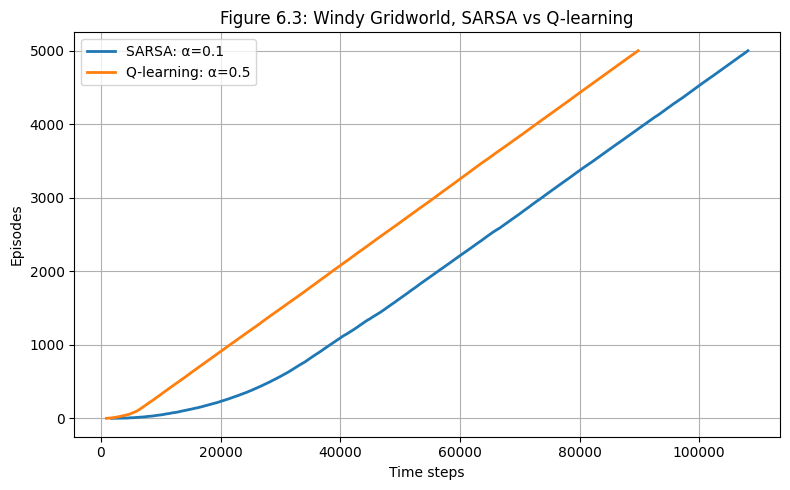

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Windy Gridworld (Example 6.5) ---
class WindyGridworldEnv:
    def __init__(self, height=7, width=10, wind=None, start=(3,0), goal=(3,7)):
        self.height, self.width = height, width
        self.wind = wind if wind else [0,0,0,1,1,1,2,2,1,0]
        self.start, self.goal = start, goal

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        x,y = self.agent_pos
        w = self.wind[y]
        x -= w
        if action==0:    x-=1      # up
        elif action==1:  x+=1      # down
        elif action==2:  y-=1      # left
        elif action==3:  y+=1      # right
        x = max(0, min(self.height-1, x))
        y = max(0, min(self.width-1,  y))
        self.agent_pos = (x,y)
        return (x,y), -1, (x,y)==self.goal, {}

# ε-greedy policy
def epsilon_greedy(Q, state, ε=0.1):
    if random.random() < ε:
        return random.randrange(4)
    return int(np.argmax(Q[state]))

# SARSA returns list of steps per episode
def sarsa(env, episodes, α=0.1, γ=1.0, ε=0.1):
    Q = {(i,j): np.zeros(4) for i in range(env.height) for j in range(env.width)}
    steps = []
    for _ in range(episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, ε)
        t = 0
        done = False
        while not done:
            nxt, r, done, _ = env.step(action)
            nxt_a = epsilon_greedy(Q, nxt, ε)
            Q[state][action] += α*(r + γ*Q[nxt][nxt_a] - Q[state][action])
            state, action = nxt, nxt_a
            t += 1
        steps.append(t)
    return steps

# Q-learning returns list of steps per episode
def q_learning(env, episodes, α=0.5, γ=1.0, ε=0.1):
    Q = {(i,j): np.zeros(4) for i in range(env.height) for j in range(env.width)}
    steps = []
    for _ in range(episodes):
        state = env.reset()
        t = 0
        done = False
        while not done:
            action = epsilon_greedy(Q, state, ε)
            nxt, r, done, _ = env.step(action)
            best_next = np.max(Q[nxt])
            Q[state][action] += α*(r + γ*best_next - Q[state][action])
            state = nxt
            t += 1
        steps.append(t)
    return steps

# --- Run both algorithms ---
env = WindyGridworldEnv()
episodes = 5000

sarsa_steps = sarsa(env, episodes)
q_steps     = q_learning(env, episodes)

# --- Compute cumulative time steps ---
cum_sarsa = np.cumsum(sarsa_steps)
cum_q     = np.cumsum(q_steps)
eps_idx   = np.arange(1, episodes+1)

# --- Plot Figure 6.3 style ---
plt.figure(figsize=(8,5))
plt.plot(cum_sarsa, eps_idx, label='SARSA: α=0.1',     linewidth=2)
plt.plot(cum_q,     eps_idx, label='Q-learning: α=0.5', linewidth=2)
plt.xlabel("Time steps")
plt.ylabel("Episodes")
plt.title("Figure 6.3: Windy Gridworld, SARSA vs Q-learning")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


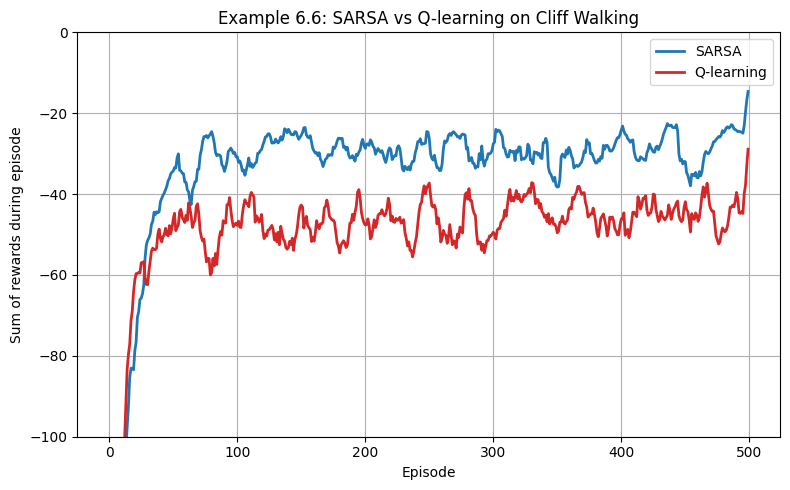

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Cliff Walking Environment ---
class CliffWalkingEnv:
    def __init__(self, height=4, width=12):
        self.height = height
        self.width = width
        self.start  = (3, 0)
        self.goal   = (3, 11)
        self.reset()

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:   x -= 1       # up
        elif action == 1: x += 1       # down
        elif action == 2: y -= 1       # left
        elif action == 3: y += 1       # right

        # keep in bounds
        x = max(0, min(self.height-1, x))
        y = max(0, min(self.width-1,  y))
        self.agent_pos = (x, y)

        # fell off the cliff
        if x == 3 and 1 <= y <= 10:
            return self.start, -100, False, {}
        # reached the goal
        if self.agent_pos == self.goal:
            return self.agent_pos, -1, True, {}
        # regular step
        return self.agent_pos, -1, False, {}

# ε‐greedy policy
def epsilon_greedy(Q, state, n_actions, ε):
    if random.random() < ε:
        return random.randrange(n_actions)
    return int(np.argmax(Q[state]))

# run one full SARSA experiment, return sum‐of‐rewards per episode
def run_sarsa_rewards(env, episodes, α=0.5, γ=1.0, ε=0.1):
    Q = { (i,j): np.zeros(4)
          for i in range(env.height)
          for j in range(env.width) }
    rewards = []
    for _ in range(episodes):
        state  = env.reset()
        action = epsilon_greedy(Q, state, 4, ε)
        done   = False
        total_r = 0
        while not done:
            next_state, r, done, _ = env.step(action)
            total_r += r
            next_action = epsilon_greedy(Q, next_state, 4, ε)
            # SARSA update
            Q[state][action] += α * (
                r + γ * Q[next_state][next_action]
                  - Q[state][action]
            )
            state, action = next_state, next_action
        rewards.append(total_r)
    return np.array(rewards)

# run one full Q-learning experiment, return sum‐of‐rewards per episode
def run_q_rewards(env, episodes, α=0.5, γ=1.0, ε=0.1):
    Q = { (i,j): np.zeros(4)
          for i in range(env.height)
          for j in range(env.width) }
    rewards = []
    for _ in range(episodes):
        state = env.reset()
        done  = False
        total_r = 0
        while not done:
            action = epsilon_greedy(Q, state, 4, ε)
            next_state, r, done, _ = env.step(action)
            total_r += r
            # Q-learning update
            best_next = np.max(Q[next_state])
            Q[state][action] += α * (
                r + γ * best_next
                  - Q[state][action]
            )
            state = next_state
        rewards.append(total_r)
    return np.array(rewards)

# --- Parameters ---
n_episodes = 500
n_runs     = 20
α = 0.5; γ = 1.0; ε = 0.1

env = CliffWalkingEnv()

# collect and average across runs
sarsa_all = np.stack([run_sarsa_rewards(env, n_episodes, α,γ,ε)
                      for _ in range(n_runs)])
q_all     = np.stack([run_q_rewards(  env, n_episodes, α,γ,ε)
                      for _ in range(n_runs)])

sarsa_mean = sarsa_all.mean(axis=0)
q_mean     = q_all.mean(axis=0)

# light moving‐average smoothing
def smooth(x, w=10):
    return np.convolve(x, np.ones(w)/w, mode='same')

sarsa_s = smooth(sarsa_mean)
q_s     = smooth(q_mean)

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(sarsa_s, label='SARSA', color='tab:blue', linewidth=2)
plt.plot(q_s,     label='Q-learning', color='tab:red', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards during episode")
plt.title("Example 6.6: SARSA vs Q-learning on Cliff Walking")
plt.legend()
plt.grid(True)
plt.ylim(-100, 0)
plt.tight_layout()
plt.show()


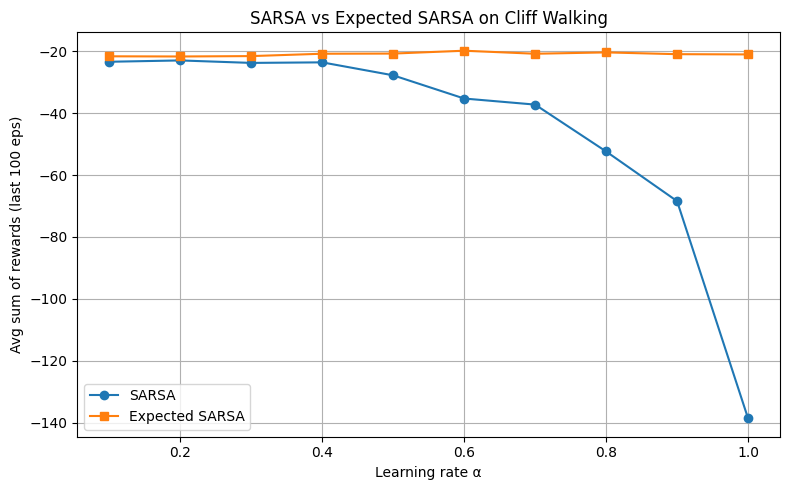

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Cliff Walking Environment ---
class CliffWalkingEnv:
    def __init__(self, height=4, width=12):
        self.height = height
        self.width = width
        self.start = (3, 0)
        self.goal  = (3, 11)

    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        if action == 0:   x -= 1  # up
        elif action == 1: x += 1  # down
        elif action == 2: y -= 1  # left
        elif action == 3: y += 1  # right
        x = max(0, min(self.height - 1, x))
        y = max(0, min(self.width  - 1, y))
        self.agent_pos = (x, y)
        if x == 3 and 1 <= y <= 10:           # fell off cliff
            return self.start, -100, False, {}
        if self.agent_pos == self.goal:       # reached goal
            return self.agent_pos, -1, True, {}
        return self.agent_pos, -1, False, {}  # normal step

# ε-greedy action selection
def epsilon_greedy_action(Q, state, ε):
    if random.random() < ε:
        return random.randrange(4)
    vals = Q[state]
    max_val = max(vals)
    return random.choice([a for a,v in enumerate(vals) if v == max_val])

# Compute expected Q for Expected SARSA
def expected_q(Q, state, ε):
    vals = Q[state]
    n = len(vals)
    max_val = max(vals)
    max_actions = [i for i,v in enumerate(vals) if v == max_val]
    m = len(max_actions)
    exp = 0.0
    for a in range(n):
        pi = ((1-ε)/m + ε/n) if a in max_actions else (ε/n)
        exp += pi * vals[a]
    return exp

# Run one episode (SARSA or Expected SARSA)
def run_episode(env, Q, α, γ, ε, expected=False):
    state = env.reset()
    action = epsilon_greedy_action(Q, state, ε)
    total_reward = 0
    done = False
    while not done:
        nxt, r, done, _ = env.step(action)
        total_reward += r
        if expected:
            target = r + γ * expected_q(Q, nxt, ε)
            Q[state][action] += α * (target - Q[state][action])
            action = epsilon_greedy_action(Q, nxt, ε)
        else:
            nxt_a = epsilon_greedy_action(Q, nxt, ε)
            target = r + γ * Q[nxt][nxt_a]
            Q[state][action] += α * (target - Q[state][action])
            action = nxt_a
        state = nxt
    return total_reward

# Experiment over different alphas
def experiment(algorithm, alphas, episodes=500, runs=10, γ=1.0, ε=0.1):
    rewards = np.zeros((len(alphas), episodes))
    for i, α in enumerate(alphas):
        for _ in range(runs):
            env = CliffWalkingEnv()
            Q = {(r,c): np.zeros(4) for r in range(env.height) for c in range(env.width)}
            for ep in range(episodes):
                r = run_episode(env, Q, α, γ, ε, expected=(algorithm=='expected'))
                rewards[i, ep] += r
        rewards[i] /= runs
    return rewards

# --- Main ---
if __name__ == "__main__":
    alphas = np.linspace(0.1, 1.0, 10)
    episodes = 500

    sarsa_rewards = experiment('sarsa',   alphas, episodes)
    exp_rewards   = experiment('expected', alphas, episodes)

    # metric: average over last 100 episodes
    metric_sarsa = sarsa_rewards[:, -100:].mean(axis=1)
    metric_exp   = exp_rewards[:,   -100:].mean(axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(alphas, metric_sarsa, marker='o', label='SARSA')
    plt.plot(alphas, metric_exp,   marker='s', label='Expected SARSA')
    plt.xlabel('Learning rate α')
    plt.ylabel('Avg sum of rewards (last 100 eps)')
    plt.title('SARSA vs Expected SARSA on Cliff Walking')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
